In [113]:
import time

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

In [114]:
def get_train_test_revenue(df):
    df['revenue'] = df['META__revenue']
#     dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col and not 'cast' in col and not 'crew' in col]]
    dff = df[[col for col in df.columns if not 'META' in col and not 'PROCESS' in col and not 'profitability' in col]]
    X = dff.drop(['revenue'], axis=1)
    y = dff['revenue']
    return X, y

In [115]:
def discard_extremes(df, n, col):
    return df[(~df[col].isin(df.nlargest(n, col)[col]))&(~df[col].isin(df.nsmallest(n, col)[col]))]

In [116]:
df = pd.read_csv('savedcsv/17_homepage.csv')
df = discard_extremes(df, 10, 'META__revenue')

num_in_train = int(df.shape[0]*0.8)
df_train = df[:num_in_train]
df_test = df[num_in_train:]
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
# Create a model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

mod_mlp = MLPRegressor(
    solver='adam',
    hidden_layer_sizes=(100,),
    activation='relu',
    max_iter=10000)

mod_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))

mod_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

mod_cat = CatBoostRegressor(iterations=10000, learning_rate=0.01,
                            depth=5, eval_metric='RMSE',
                            colsample_bylevel=0.7, random_seed = 17, silent=True,
                            bagging_temperature = 0.2, early_stopping_rounds=200)

mod_gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)

mod_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread=-1)

mod_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=8,
                              learning_rate=0.05, n_estimators=650,
                              max_bin=58, bagging_fraction=0.80,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=7, min_sum_hessian_in_leaf=11)

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
mod_rfr = RandomForestRegressor(n_estimators=100, min_samples_split=3, random_state=0, n_jobs=-1)

# mod_dummy = DummyRegressor(strategy='median')
mod_dummy = DummyRegressor()
    
mod_stacked = StackingAveragedModels(base_models = (mod_cat, mod_xgb, mod_gboost, mod_lgb), meta_model = mod_lasso)

In [129]:
class Process:
    def __init__(self, 
                 X_train, X_test, y_train, y_test, 
                 imputer='mean', 
                 minmaxrange=(0,1), 
                 standardize_X=True,
                 standardize_y=True,
                ):
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self, inverse=False):
        def scaler_transform(obj):
            return self.X_minmaxscaler.transform(obj)
        
        def scaler_transform_inverse(obj):
            return self.X_minmaxscaler.inverse_transform(obj)
        
        if inverse:
            self.X_train[:] = scaler_transform_inverse(self.X_train)
            self.X_test[:] = scaler_transform_inverse(self.X_test)
        else:
            self.X_minmaxscaler.fit(self.X_train)
            self.X_train[:] = scaler_transform(self.X_train)
            self.X_test[:] = scaler_transform(self.X_test)
        return self
    
    def minmaxscale_Y(self, inverse=False):
        def scaler_transform(obj):
            return self.y_minmaxscaler.transform(obj)
        
        def scaler_transform_inverse(obj):
            return self.y_minmaxscaler.inverse_transform(obj)
        
        if inverse:
            self.y_train[:] = scaler_transform_inverse(self.y_train)
            self.y_test[:] = scaler_transform_inverse(self.y_test)
        else:
            self.y_minmaxscaler.fit(self.y_train)
            self.y_train[:] = scaler_transform(self.y_train)
            self.y_test[:] = scaler_transform(self.y_test)
        return self
    
    def make_target_positive(self):
        self.min_y_train = min(self.y_train)
        self.y_train = self.y_train - self.min_y_train + 1
        self.y_test = self.y_test - self.min_y_train + 1
        return self
        
    def return_target_back_from_positive(self):
        self.y_train = self.y_train + self.min_y_train - 1
        self.y_test = self.y_test + self.min_y_train - 1
        return self
    
    def return_target_back_from_positive(self, obj):
        return obj + self.min_y_train - 1
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.y_train.flatten(), self.y_test.flatten()       

In [130]:
#Validation function
n_folds = 10
def rmsle_cv(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    return np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1))

def eval_model(model, name, X, y):
    start_time = time.time()
    score = rmsle_cv(model, X, y)
    print("{} score: {:.4f} ({:.4f}),     execution time: {:.1f}".format(name, score.mean(), score.std(), time.time()-start_time))


def eval_models(X, y):
#     eval_model(mod_mlp, "mlp", X, y)
#     eval_model(mod_lasso, "lasso", X, y)
#     eval_model(mod_enet, "enet", X, y)
    eval_model(mod_cat, "cat", X, y)
    eval_model(mod_gboost, "gboost", X, y)
    eval_model(mod_xgb, "xgb", X, y)
    eval_model(mod_lgb, "lgb", X, y)
#     eval_model(mod_stacked, "stacked", X, y)





# ---------------------------------------------------------------------
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': sum(abs((y_test - y_pred)/y_test)),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'mse': metrics.mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'r2': r2,
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]}')
    return res

def predict(model, model_name, X_train, y_train, X_test, y_test):
    print()
    print(model_name)
    model.fit(X_train.values, y_train)
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def predict_test(X_train, y_train, X_test, y_test):
    prediction_results = {}
    prediction_results['dummy'] = predict(mod_dummy, 'dummy', X_train, y_train, X_test, y_test)
#     prediction_results['mlp'] = predict(mod_mlp, 'mlp', X_train, y_train, X_test, y_test)        
#     prediction_results['lasso'] = predict(mod_lasso, 'lasso', X_train, y_train, X_test, y_test)
#     prediction_results['enet'] = predict(mod_enet, 'enet', X_train, y_train, X_test, y_test)
#     prediction_results['xgb'] = predict(mod_xgb, 'xgb', X_train, y_train, X_test, y_test)
#     prediction_results['gboost'] = predict(mod_gboost, 'gboost', X_train, y_train, X_test, y_test)
#     prediction_results['lgb'] = predict(mod_lgb, 'lgb', X_train, y_train, X_test, y_test)
#     prediction_results['rfr'] = predict(mod_rfr, 'rfr', X_train, y_train, X_test, y_test)
#     prediction_results['mod_stacked'] = predict(mod_stacked, 'mod', X_train, y_train, X_test, y_test)
    return prediction_results

# ---------------------------------------------------------------------
def print_graphs(actual, predicted, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(res, process=None):
    for i in res:
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print(i)
        print('train')
        print_graphs(res[i]['actual']['train'], res[i]['predictions']['train'])
        print('test')        
        print_graphs(res[i]['actual']['test'], res[i]['predictions']['test'])
        
        if process:
            train_real = process.skew_y_inverse(res[i]['actual']['train'])
            test_real = process.skew_y_inverse(res[i]['actual']['test'])
            pred_train_real = process.skew_y_inverse(res[i]['predictions']['train'])
            pred_test_real = process.skew_y_inverse(res[i]['predictions']['test'])

            print('train real values')
            print_graphs(train_real, pred_train_real)
            print('test real values')
            print_graphs(test_real, pred_test_real)

In [111]:
data = {}
process = Process(X_train, X_test, y_train, y_test, imputer='mean').skew_X().skew_y().minmaxscale_X().fill_nan()
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
data['X_train'] = Xh_train
data['X_test'] = Xh_test
data['y_train'] = yh_train
data['y_test'] = yh_test


dummy
train
mape: 5987.507038293008
mae: 0.7999768487720232
mse: 1.0000011498020471
rmse: 1.0000005749008583
r2: -1.149802050237625e-06
adj_r2: -0.0391112243206424
test
mape: 1495.3476342313095
mae: 1.0186195008085746
mse: 1.4915596858177058
rmse: 1.221294266676834
r2: -0.04858538586862027
adj_r2: -0.23450478052617707
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dummy
train


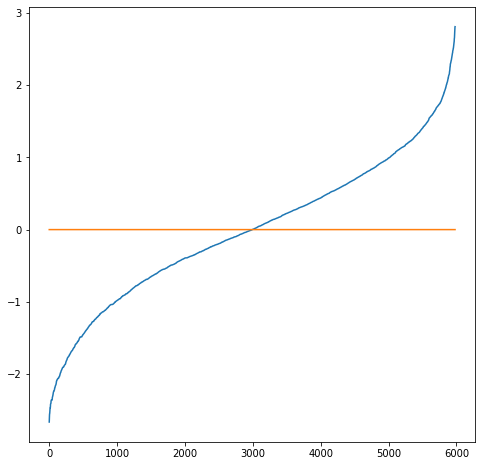

test


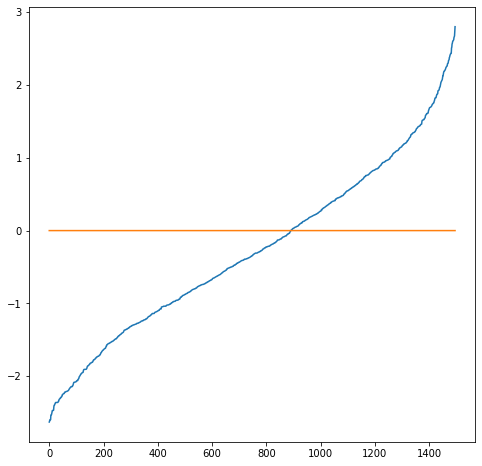

train real values


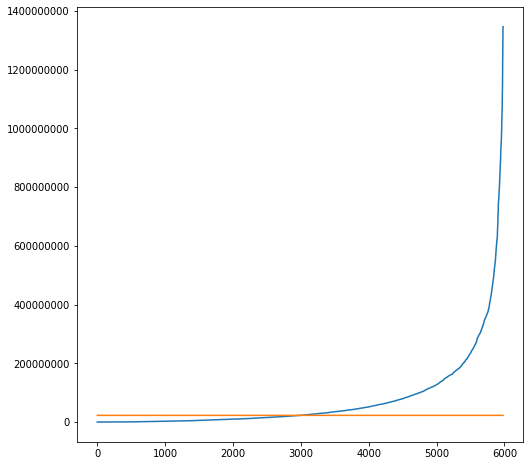

test real values


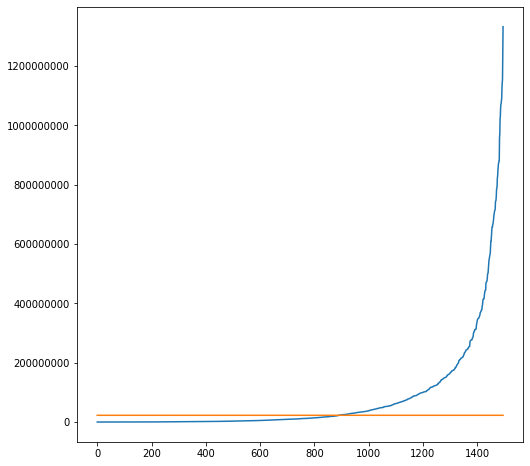

In [125]:
results = predict_test(data['X_train'], data['y_train'], data['X_test'], data['y_test'])
print_sorted_actual_to_predicted_graphs(results, process)

In [126]:
data = {}
process = Process(X_train, X_test, y_train, y_test, imputer='mean').skew_X().minmaxscale_X().fill_nan()
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
data['X_train'] = Xh_train
data['X_test'] = Xh_test
data['y_train'] = yh_train
data['y_test'] = yh_test


dummy
train
mape: 1165879.5811588648
mae: 82466862.75219868
mse: 1.9888365932268976e+16
rmse: 141026117.9082406
r2: 0.0
adj_r2: -0.03911002954980014
test
mape: 883883.6651071146
mae: 97249780.4033559
mse: 2.9127522684428908e+16
rmse: 170667872.44361168
r2: -0.000455149774845065
adj_r2: -0.17784081462854107
^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dummy
train


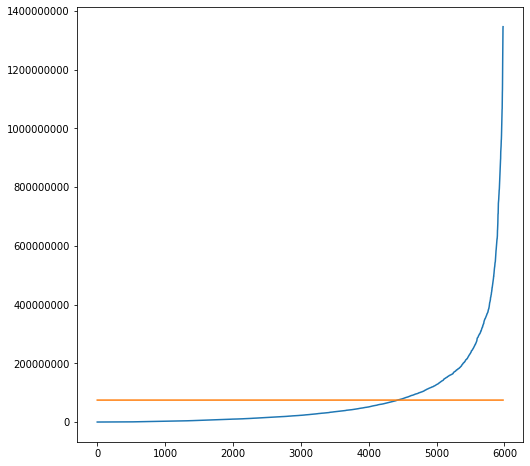

test


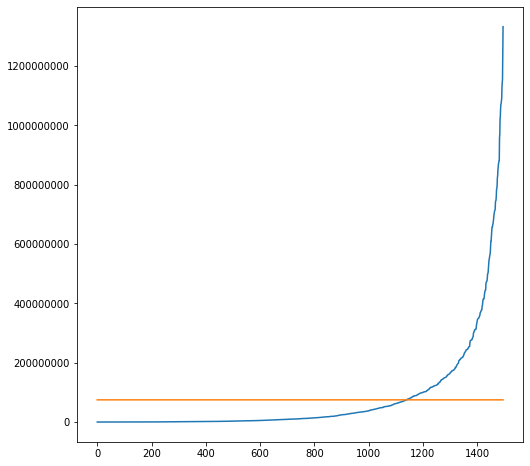

In [131]:
results = predict_test(data['X_train'], data['y_train'], data['X_test'], data['y_test'])
print_sorted_actual_to_predicted_graphs(results)

In [ ]:
process = Process(X_train, X_test, y_train, y_test, imputer='knn').skew_X().minmaxscaleX().fill_nan()
Xh_train, Xh_test, yh_train, yh_test = process.return_processed()
yh_train = np.log1p(yh_train)

In [ ]:
estimator = RandomForestRegressor(n_estimators=100, min_samples_split=3, random_state=0, n_jobs=-1)
selector = RFECV(estimator, verbose=10, n_jobs=-1)

In [ ]:
selector = selector.fit(Xh_train, yh_train)

In [ ]:
import joblib
joblib.dump(selector, 'rfecv_selector_joblib_2.sav')
import pickle
pickle.dump(selector, open('rfecv_selector_pickle_2.sav', 'wb'))

In [ ]:
selector.n_features_
selector.support_
selector.ranking_

In [ ]:
ind = selector.get_support()
not_ind = [not val for val in ind]
list(Xh_train.columns[ind])

In [ ]:
pd.options.display.float_format = '{:20,.15f}'.format
print(Xh_train.astype(float).describe())

In [ ]:
pd.options.display.float_format = '{:20,.15f}'.format
print(Xh_train.astype(float).describe())

In [ ]:
list(X_train.columns[not_ind])

In [ ]:
selector.score(Xh_test, yh_test)

In [ ]:
selector.score(Xh_train, yh_train)

In [ ]:
selector.ranking_

In [ ]:
selector.estimator_.feature_importances_ 

In [ ]:
# rank = [(list(X_train.columns)[i], list(selector.ranking_)[i]) for i in range(len(X_train.columns))]
rank = [(list(X_train.columns)[i], list(selector.estimator_.feature_importances_)[i]) for i in range(len(X_train.columns))]

In [ ]:
feature_names = list(X_train.columns.values)
print(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), feature_names)))

In [ ]:
sorted(rank, key=lambda tup: tup[1])

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
scoring = ['neg_mean_squared_error']

def predict_cv_model(model, name, X, y):
    return cross_val_predict(model, X.values, y, cv=20, n_jobs=-1)


def eval_models(X, y):
#     eval_model(mod_mlp, "mlp", X, y)
    return predict_cv_model(mod_lasso, "lasso", X, y)
#     eval_model(mod_enet, "enet", X, y)
#     eval_model(mod_cat, "cat", X, y)
#     eval_model(mod_gboost, "gboost", X, y)
#     eval_model(mod_xgb, "xgb", X, y)
#     eval_model(mod_lgb, "lgb", X, y)
#     eval_model(mod_stacked, "stacked", X, y)





# ---------------------------------------------------------------------
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': sum(abs((y_test - y_pred)/y_test)),
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'mse': metrics.mean_squared_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'r2': r2,
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]}')
    return res

def predict_not_log(model, model_name, X_train, y_train, X_test, y_test):
    print()
    print(model_name)
    model.fit(X_train.values, y_train)
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def predict_test(X_train, y_train, X_test, y_test):
    prediction_results = {}
#     prediction_results['mlp'] = predict(mod_mlp, 'mlp', X_train, y_train, X_test, y_test)        
    prediction_results['lasso'] = predict(mod_lasso, 'lasso', X_train, y_train, X_test, y_test)
#     prediction_results['enet'] = predict(mod_enet, 'enet', X_train, y_train, X_test, y_test)
#     prediction_results['xgb'] = predict(mod_xgb, 'xgb', X_train, y_train, X_test, y_test)
#     prediction_results['gboost'] = predict(mod_gboost, 'gboost', X_train, y_train, X_test, y_test)
#     prediction_results['lgb'] = predict(mod_lgb, 'lgb', X_train, y_train, X_test, y_test)
#     prediction_results['mod_stacked'] = predict(mod_stacked, 'mod', X_train, y_train, X_test, y_test)
    return prediction_results

# ---------------------------------------------------------------------
def print_graphs(actual, predicted, log=False):
    plt.clf()
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='actual')
    plt.plot(x, res_df['predicted'], label='predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if log:
        plt.yscale('log')
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(res):
    print('train')
    print_graphs(res['actual']['train'], res['predictions']['train'])
    print('test')
    print_graphs(res['actual']['test'], res['predictions']['test'])

In [ ]:
df = pd.read_csv('savedcsv/17_homepage.csv')
num_in_train = int(df.shape[0]*0.8)
df_train = df[:num_in_train]
df_test = df[num_in_train:]
X_train, y_train = get_train_test_revenue(df_train)
X_test, y_test = get_train_test_revenue(df_test)

In [ ]:
process = Process(X_train, X_test, y_train, y_test, imputer='knn').skew_X().minmaxscaleX().fill_nan()

In [ ]:
skew = PowerTransformer()
Xh_train, Xh_test, y_train, yh_test = process.return_processed()
yh_train = skew.fit_transform(y_train.reshape(-1, 1)).flatten()

In [ ]:
mod_cat.fit(Xh_train.values, yh_train)
pred_train = mod_cat.predict(Xh_train.values)
pred_skew = mod_cat.predict(Xh_test.values)
pred_test = skew.inverse_transform(pred_skew.reshape(-1, 1)).flatten()
result = {
    'res': {
        'train': print_metrics('train', yh_train, pred_train, Xh_train.shape[1]),
        'test': print_metrics('test', yh_test, pred_test, Xh_test.shape[1]),
    },
    'predictions':{
        'train': pred_train,
        'test': pred_test,
    },
    'actual': {
        'train': yh_train,
        'test': yh_test,
    },
}

In [ ]:
print_sorted_actual_to_predicted_graphs(result)

In [ ]:
mod_enet.fit(Xh_train.values, yh_train)
pred_train = mod_enet.predict(Xh_train.values)
pred_skew = mod_enet.predict(Xh_test.values)
pred_test = skew.inverse_transform(pred_skew.reshape(-1, 1)).flatten()
result = {
    'res': {
        'train': print_metrics('train', yh_train, pred_train, Xh_train.shape[1]),
        'test': print_metrics('test', yh_test, pred_test, Xh_test.shape[1]),
    },
    'predictions':{
        'train': skew.inverse_transform(pred_train.reshape(-1, 1)).flatten(),
        'test': pred_test,
    },
    'actual': {
        'train': skew.inverse_transform(yh_train.reshape(-1, 1)).flatten(),
        'test': yh_test,
    },
}

In [ ]:
print_sorted_actual_to_predicted_graphs(result)

In [ ]:
df_describe = pd.DataFrame(pred_train)
df_describe.describe()

In [ ]:
df_describe = pd.DataFrame(pred_test)
df_describe.describe()

In [ ]:
plt.plot(np.sort(pred_train))
plt.show()

In [ ]:
plt.plot(np.sort(pred_test))
plt.show()

In [ ]:
yh_train

In [ ]:
df_describe = pd.DataFrame(yh_test)
df_describe.describe()

In [ ]:
print_graphs(y_train, y_pred)